In [ ]:
!apt-get install -y python-rtree;
!pip install geopandas sodapy shapely rtree cenpy;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.


In [ ]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
from sodapy import Socrata
import cenpy
from scipy.stats import pearsonr
from shapely import wkt
from shapely.geometry import shape
from shapely.ops import nearest_points
import urllib.request, json 
from shapely.geometry import Point, Polygon

In [ ]:
#use socrata personal key
client = Socrata("data.cityofnewyork.us", 'S8JvsbGoDguEN16oahuM1PMae')

#pull prop value data,json url code, simplified boro to only manhattan akak 1, then limit to 1 mil entries
valuation = client.get("yjxr-fw8i", where='BORO = 1',limit=100000000)

#pull hbldg footprint data, json url code, limit to 2 mil
bldgs = client.get("cn3y-d5py", limit=2000000)


In [ ]:
#renaming valuation to manhattan prop df
manhattan_prop_df = pd.DataFrame.from_dict(valuation)

In [ ]:
#renaming bldgs to manhattan ftprints
manhattan_footprints= pd.DataFrame.from_dict(bldgs)

In [ ]:
manhattan_prop_df 

,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,staddr,zip,bldfront,blddepth,avland2,avtot2,period,year,valtype,borough,latitude,longitude,community_board,council_district,census_tract,bin,nta,geocoded_column,excd1,exland2,extot2,ext,exmptcl,easement,excd2
0,1010401210,1,1040,1210,"H&G WARNER, LLC",R4,2,0,0,35,113465,12707,51059,0,0,350 WEST 50 STREET,10019,200,327,12707,47727,FINAL,2010/11,AC-TR,MANHATTAN,40.762988,-73.987791,104,3,127,1077841,Clinton,"{'type': 'Point', 'coordinates': [-73.987791, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1008901282,1,890,1282,"SPERBER, LORRAINE",R4,2,0,0,19,135599,11877,61020,0,0,155 EAST 34 STREET,10016,0,0,11877,53712,FINAL,2010/11,AC-TR,MANHATTAN,40.746162,-73.979129,106,2,72,1018549,Murray Hill-Kips Bay,"{'type': 'Point', 'coordinates': [-73.979129, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1009681288,1,968,1288,ROOS ESTHER A,R4,2,0,0,37,222481,39824,100116,2090,2090,630 1 AVENUE,10016,0,0,39824,96085,FINAL,2010/11,AC-TR,MANHATTAN,40.745156,-73.9725,106,4,8601,1022060,Turtle Bay-East Midtown,"{'type': 'Point', 'coordinates': [-73.9725, 40...",1017,2090,2090,NaN,NaN,NaN,NaN
3,1008701611,1,870,1611,BARRETO ANITA,R4,2,244,425,27,172555,21306,77650,0,0,1 IRVING PLACE,10003,0,0,21306,75826,FINAL,2010/11,AC-TR,MANHATTAN,40.734072,-73.988713,105,2,50,1083247,Gramercy,"{'type': 'Point', 'coordinates': [-73.988713, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1010381112,1,1038,1112,NaN,R4,2,0,0,43,175784,4698,79103,1270,75675,306 WEST 48 STREET,10036,23,100,4120,79714,FINAL,2010/11,AC-TR,MANHATTAN,40.761262,-73.987572,104,3,127,1087980,Clinton,"{'type': 'Point', 'coordinates': [-73.987572, ...",5110,692,76286,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1382559,1007650020,1,765,20,EVGER 15TH STREET REA,C4,2,25,103,5,782000,99900,351900,0,0,229 WEST 15 STREET,10011,25,92,99900,324000,FINAL,2010/11,AC-TR,MANHATTAN,40.739672,-74.000173,104,3,81,1013768,Hudson Yards-Chelsea-Flatiron-Union Square,"{'type': 'Point', 'coordinates': [-74.000173, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382560,1008690024,1,869,24,PARSONAGE HILL VILL.A,O1,4,35,100,5,3410000,1237500,1534500,0,0,263 MADISON AVENUE,10016,35,100,1237500,1532700,FINAL,2010/11,AC-TR,MANHATTAN,40.750993,-73.980597,106,4,82,1017591,Murray Hill-Kips Bay,"{'type': 'Point', 'coordinates': [-73.980597, ...",NaN,NaN,NaN,E,NaN,NaN,NaN
1382561,1007640075,1,764,75,92 EIGHTH AVENUE REAL,C4,2B,25,93,4,3340000,127622,448692,0,0,92 8 AVENUE,10011,26,55,NaN,NaN,FINAL,2010/11,AC-TR,MANHATTAN,40.740141,-74.002227,104,3,81,1000000,Hudson Yards-Chelsea-Flatiron-Union Square,"{'type': 'Point', 'coordinates': [-74.002227, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382562,1006260047,1,626,47,HEALY DONALL B,S4,2A,24,88,4,6460000,178647,309400,0,0,35 JANE STREET,10014,25,40,NaN,NaN,FINAL,2010/11,AC-TR,MANHATTAN,40.738143,-74.004471,102,3,77,1077100,West Village,"{'type': 'Point', 'coordinates': [-74.004471, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#only 2018/2019 data
manhattan_prop_df = manhattan_prop_df[manhattan_prop_df['year'] == '2018/19']
manhattan_prop_df['bbl'] = manhattan_prop_df['boro'] + manhattan_prop_df['block'] + manhattan_prop_df['lot']

In [ ]:
manhattan_prop_df = manhattan_prop_df.dropna(subset=['latitude'])
print(manhattan_prop_df.shape)
manhattan_prop_df.head(2)

(160877, 41)


,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,staddr,zip,bldfront,blddepth,avland2,avtot2,period,year,valtype,borough,latitude,longitude,community_board,council_district,census_tract,bin,nta,geocoded_column,excd1,exland2,extot2,ext,exmptcl,easement,excd2,bbl
2648,1002007501,1,200,7501,OWNER / AGENT,R0,2,0,0,6,0,0,0,0,0,198 CANAL STREET,10013,0,0,NaN,NaN,FINAL,2018/19,AC-TR,MANHATTAN,40.716989,-73.998297,103,1,29,1080816,Chinatown,"{'type': 'Point', 'coordinates': [-73.998297, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12007501
7656,1003967501,1,396,7501,NaN,R0,2,49,88,8,0,0,0,0,0,215 AVENUE B,10009,0,0,NaN,NaN,FINAL,2018/19,AC-TR,MANHATTAN,40.728875,-73.978428,103,2,28,1088495,Lower East Side,"{'type': 'Point', 'coordinates': [-73.978428, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13967501


In [ ]:
#renaming geocoded column to geom, then converting the existing data to a str that shapely can read (google), that is what coords=; for wktloads
manhattan_prop_df.rename(columns={'geocoded_column': 'geom'}, inplace=True)
coords = [str(Point(entry['coordinates'])) for entry in manhattan_prop_df['geom']]
manhattan_prop_df['geom'] = coords
manhattan_prop_df['geom'] = manhattan_prop_df['geom'].apply(wkt.loads)

In [ ]:
coords2 = [str(Polygon(entry['coordinates'][0][0])) for entry in manhattan_footprints['the_geom']]
manhattan_footprints['the_geom'] = coords2
print(manhattan_footprints.shape)
manhattan_footprints['the_geom'] = manhattan_footprints['the_geom'].apply(wkt.loads)
manhattan_footprints.head(2)

(1084904, 15)


,bin,cnstrct_yr,the_geom,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,name
0,3394646,2009,POLYGON ((-73.87129515296562 40.65717370043455...,2017-08-22T00:00:00.000Z,Constructed,1212853,21.60850812,2100,18,854.66243317866,125.0797955584,3044520815,3044520815,Photogramm,NaN
1,4548330,1930,POLYGON ((-73.87670970144625 40.71425234541623...,2017-08-17T00:00:00.000Z,Constructed,1226227,10.36,5110,122,217.59424346169,60.22585821856,4030640041,4030640041,Photogramm,NaN


In [ ]:

Polygon(manhattan_footprints['the_geom'][0]['coordinates'][0][0])

TypeError: ignored

In [ ]:
manhattan_footprints = gpd.GeoDataFrame(manhattan_footprints, geometry='the_geom')
manhattan_prop_df = gpd.GeoDataFrame(manhattan_prop_df, geometry='geom')
manhattan_footprints = manhattan_footprints.set_crs(epsg=3857)
manhattan_prop_df = manhattan_prop_df.set_crs(epsg=3857)

In [ ]:
combined = manhattan_footprints.merge(manhattan_prop_df, left_on='mpluto_bbl',
                       right_on='bble')

In [ ]:
classes = ['1', '2', '2A', '2B', '1D', '2C', '1B']
combined = combined[combined['taxclass'].isin(classes)]

In [ ]:
print(combined.shape)
combined.head(1)

(34390, 56)


,bin_x,cnstrct_yr,the_geom,lstmoddate,lststatype,doitt_id,heightroof,feat_code,groundelev,shape_area,shape_len,base_bbl,mpluto_bbl,geomsource,name,bble,boro,block,lot,owner,bldgcl,taxclass,ltfront,ltdepth,stories,fullval,avland,avtot,exland,extot,staddr,zip,bldfront,blddepth,avland2,avtot2,period,year,valtype,borough,latitude,longitude,community_board,council_district,census_tract,bin_y,nta,geom,excd1,exland2,extot2,ext,exmptcl,easement,excd2,bbl
1,1039988,1931,POLYGON ((-73.96425191767109 40.75860443341254...,2017-08-22T00:00:00.000Z,Constructed,66240,167.21446831,2100,52,4652.20272097352,302.5855511998,1013490035,1013490035,Photogramm,NaN,1013490035,1,1349,35,340 EAST 57TH ST ASSO,D6,2,116,71,16,12329000,1530000,5548050,0,0,340 EAST 57 STREET,10022,102,50,1530000,5301900,FINAL,2018/19,AC-TR,MANHATTAN,40.758759,-73.964008,106,5,108,1039988,Turtle Bay-East Midtown,POINT (-73.96400800000001 40.758759),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1134935


In [ ]:
poi = client.get("c49g-hsw9", limit=25500)
poi_df = pd.DataFrame.from_records(poi)

In [ ]:
poi_df['the_geom'] = poi_df['the_geom'].apply(lambda x: shape(x))

In [ ]:
poi_df = gpd.GeoDataFrame(poi_df, geometry='the_geom')
poi_df = poi_df.set_crs(epsg=3857)

In [ ]:
places = ['bike' 'green' 'park' 'recreation' 'health']
bike_df = poi_df[(poi_df['facility_t']=='6') & 
                    (poi_df['name'].str.lower().str.contains('|'.join(places)))]

In [ ]:
bike_df

,saftype,the_geom,complexid,segmentid,sos,placeid,faci_dom,bin,borough,created,modified,facility_t,source,b7_sc,pri_add,name
2,N,POINT (-73.95802 40.75849),0,138896,1,1026908,8,0,1,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,19792015,0,KOCH BR PEDESTRIAN AND BIKE PATH
3,N,POINT (-73.95062 40.75530),0,139388,1,1026909,8,0,4,2015-10-20T00:00:00.000Z,2020-03-16T00:00:00.000Z,6,DoITT,49734017,0,KOCH BR PEDESTRIAN AND BIKE
32,N,POINT (-73.92688 40.84643),0,297515,2,1026966,8,0,2,2015-10-23T00:00:00.000Z,2017-07-28T00:00:00.000Z,6,DoITT,29820004,0,WASHINGTON BR PED AND BIKE
35,N,POINT (-73.93357 40.81958),0,295140,1,1026910,8,0,1,2015-10-21T00:00:00.000Z,2018-04-19T00:00:00.000Z,6,OTHER,19775004,0,145 ST BRIDGE PED AND BIKE
36,N,POINT (-73.93313 40.80739),0,241749,2,1026929,8,0,1,2015-10-23T00:00:00.000Z,2018-04-19T00:00:00.000Z,6,DoITT,19771002,0,3 AV BRIDGE PED AND BIKE
46,N,POINT (-73.93213 40.81948),0,262102,1,1026911,8,0,2,2015-10-21T00:00:00.000Z,NaN,6,OTHER,29830007,0,145 ST BRIDGE PED AND BIKE
51,N,POINT (-73.92800 40.80407),15,258838,1,1026971,8,0,2,2015-10-23T00:00:00.000Z,NaN,6,DoITT,21003003,0,WILLIS AVENUE BRIDGE BIKE
53,N,POINT (-73.94366 40.76247),0,258890,1,1026956,8,0,4,2015-10-23T00:00:00.000Z,NaN,6,DoITT,49736003,0,ROOSEVELT IS BR PED & BIKE
54,N,POINT (-73.93241 40.81412),0,240167,2,1026943,8,0,2,2015-10-23T00:00:00.000Z,2020-09-01T00:00:00.000Z,6,DoITT,29827007,0,MADISON AV BRDG PED & BIKE
55,N,POINT (-73.95280 40.73910),0,235753,2,1026951,8,0,3,2015-10-23T00:00:00.000Z,NaN,6,DoITT,39740004,0,PULASKI BRIDGE BIKE


In [ ]:
for i in range(len(poi_df)):
  if 'BIKE' in poi_df['name'][i]: 
    print(poi_df['name'][i])

KOCH BR PEDESTRIAN AND BIKE PATH
KOCH BR PEDESTRIAN AND BIKE
WASHINGTON BR PED AND BIKE
145 ST BRIDGE PED AND BIKE
3 AV BRIDGE PED AND BIKE
145 ST BRIDGE PED AND BIKE
WILLIS AVENUE BRIDGE BIKE
ROOSEVELT IS BR PED & BIKE
MADISON AV BRDG PED & BIKE
PULASKI BRIDGE BIKE
PULASKI BRIDGE BIKE
RFK BRIDGE PED AND BIKE
RFK BRIDGE PED AND BIKE
BAYONNE BR PED AND BIKE
BROOKLYN BRIDGE PED AND BIKE
UNIV HEIGHTS BR BIKE AND PED
UNIV HEIGHTS BR BIKE AND PED
MARINE PY-GIL HODGES BR BIKE
MARINE PY-GIL HODGES BR BIKE
WASHINGTON BR PED AND BIKE
RFK BR QUEENS PED AND BIKE PATH
WILLIAMSBURG BR BIKE AND PED
MADISON AV BRDG PED & BIKE
CROSS BAY VET MEM BRIDGE BIKE PATH
GW BRIDGE BIKE AND PEDESTRIAN
MANHATTAN BRIDGE BIKE PATH
ROOSEVELT IS BR PED & BIKE
RFK BRIDGE BRONX PED AND BIKE PATH
RFK BR BRONX PED AND BIKE PATH
3 AVENUE BRIDGE BIKE
RFK BR QUEENS PED AND BIKE PATH
WILLIAMSBURG BR BIKE AND PED
BROOKLYN BRDG PED AND BIKE
MANHATTAN BRIDGE BIKE
WILLIS AVENUE BRIDGE BIKE
FLSHNG MDW PK BOAT & BIKE RENTAL
BROOKL

In [ ]:
bike = bike_df.the_geom.unary_union

def near(point, pts):
    # find the nearest poi
    nearest = nearest_points(point, pts)[1]
    return point.distance(nearest)

combined['distance'] = combined.apply(lambda x: near(x.the_geom.centroid, bike), axis=1)

Text(0.5, 1.0, 'Property Value by Distance to Bike Paths')

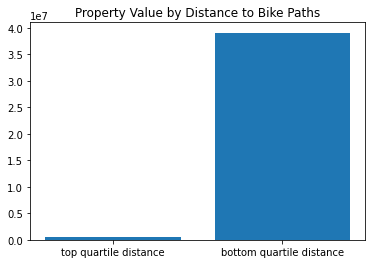

In [ ]:
combined['fullval'] = combined['fullval'].astype('int')
closer = combined[combined['fullval'] < combined['fullval'].quantile(.25)]['fullval'].mean()
further = combined[combined['fullval'] > combined['fullval'].quantile(.75)]['fullval'].mean()
plt.bar(['top quartile distance', 'bottom quartile distance'], [closer, further])
plt.title('Property Value by Distance to Bike Paths')
# Save to a PDF file
#plt.savefig('prop_val_bike.pdf')

In [ ]:
pearsonr(combined['distance'].loc[(combined['fullval'] > 200000) & (combined['fullval'] < 1000000)], 
         combined['fullval'].loc[(combined['fullval'] > 200000) & (combined['fullval'] < 1000000)])


(0.009461255351531936, 0.6103600880793767)

In [ ]:
closer

bin_x                    inf
doitt_id                 inf
feat_code                inf
base_bbl                 inf
mpluto_bbl               inf
bble                     inf
boro                     inf
block                    inf
lot                      inf
ltfront                  inf
ltdepth                  inf
fullval                  inf
avland                   inf
avtot                    inf
exland                   inf
extot                    inf
zip                      inf
bldfront                 inf
blddepth                 inf
community_board          inf
council_district         inf
census_tract             inf
easement                 NaN
bbl                      inf
distance            0.008254
dtype: float64

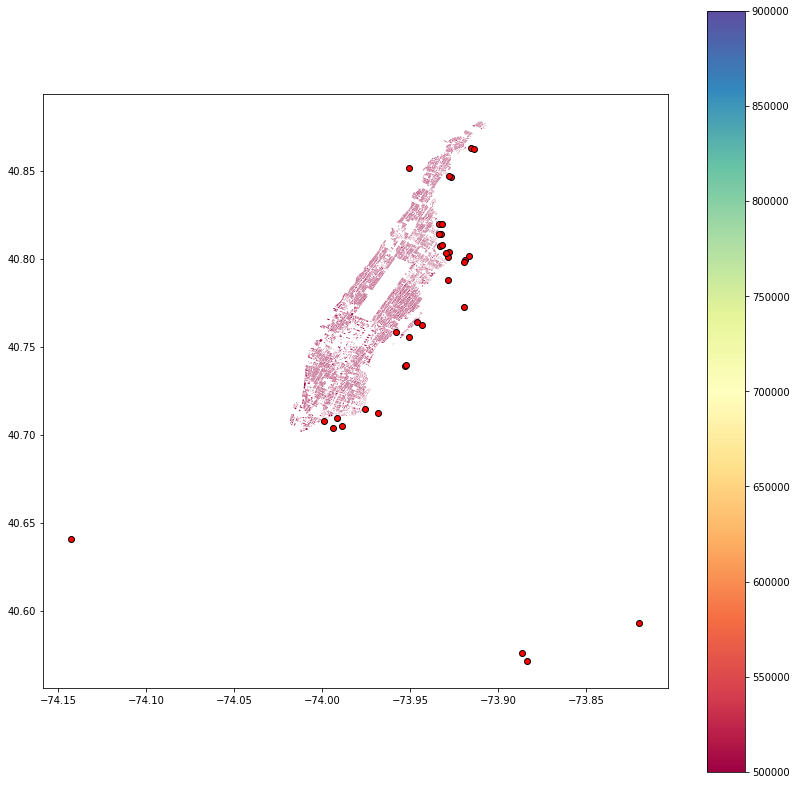

In [ ]:
ax = bike_df.plot(color='red', edgecolor="black", figsize=(14, 14))
combined.plot(column='distance', ax=ax,
              vmin=500000, vmax=900000, cmap='Spectral',
              legend=True, figsize=(14, 14)) #.loc[combined['BORO'] == '1']